In [1]:
import os
from google.colab import drive

# 1. Mount Google Drive and define paths
# This prompt will open a link; click it, select your account, and paste the authorization code.
drive.mount('/content/drive', force_remount=True)

# Define the base paths
BASE_PATH = "/content/drive/MyDrive/FaceMaskDetection"
MODEL_PATH = os.path.join(BASE_PATH, "models")
RESULTS_PATH = os.path.join(BASE_PATH, "results")
DATA_PATH = os.path.join(BASE_PATH, "data", "images") # Base dataset folder

# 2. Create necessary folders
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)
os.makedirs(os.path.join(DATA_PATH, "with_mask"), exist_ok=True)
os.makedirs(os.path.join(DATA_PATH, "without_mask"), exist_ok=True)

print("✅ Drive mounted and folder structure created:")
print(f"   Data Path: {DATA_PATH}")
print(f"   Model Path: {MODEL_PATH}")

Mounted at /content/drive
✅ Drive mounted and folder structure created:
   Data Path: /content/drive/MyDrive/FaceMaskDetection/data/images
   Model Path: /content/drive/MyDrive/FaceMaskDetection/models


In [ ]:
from google.colab import files
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ======================
# Part A: Upload Data
# ======================

# --- Upload 'with_mask' images ---
print("📤 Upload all 'with_mask' images now")
uploaded_mask = files.upload()

with_mask_path = os.path.join(DATA_PATH, "with_mask")

for filename in uploaded_mask.keys():
    shutil.move(filename, os.path.join(with_mask_path, filename))

print(f"✅ Uploaded 'with_mask' images: {len(os.listdir(with_mask_path))}")

# --- Upload 'without_mask' images ---
print("📤 Upload all 'without_mask' images now")
uploaded_nomask = files.upload()

without_mask_path = os.path.join(DATA_PATH, "without_mask")

for filename in uploaded_nomask.keys():
    shutil.move(filename, os.path.join(without_mask_path, filename))

print(f"✅ Uploaded 'without_mask' images: {len(os.listdir(without_mask_path))}")


# ======================
# Part B: Data Generators (Creates train_generator and val_generator)
# ======================

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# CRITICAL: Defines train_generator
train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training"
)

# CRITICAL: Defines val_generator
val_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

print("✅ Data generators are successfully set up.")

📤 Upload all 'with_mask' images now


✅ Uploaded 'with_mask' images: 494
📤 Upload all 'without_mask' images now


✅ Uploaded 'without_mask' images: 407
Found 722 images belonging to 2 classes.
Found 179 images belonging to 2 classes.
✅ Data generators are successfully set up.


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
import datetime

# --- Build Model (Transfer Learning) ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers (initial training)
for layer in base_model.layers:
    layer.trainable = False

# Compile and train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

EPOCHS = 10
print("\nStarting model training...")
start_time = datetime.datetime.now()

# This relies on train_generator and val_generator from Step 2
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=EPOCHS
)

end_time = datetime.datetime.now()
print(f"Training completed in {end_time - start_time}")

# Save the Model
MODEL_FILE = os.path.join(MODEL_PATH, "mask_detector_trained.keras")
model.save(MODEL_FILE)
print(f"\n✅ Model trained and saved at {MODEL_FILE}")

/tmp/ipython-input-3648751698.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))



Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.8301 - loss: 0.3203 - val_accuracy: 0.9750 - val_loss: 0.0946
Epoch 2/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 1.0000 - loss: 0.0055

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9750 - val_loss: 0.0869
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.9779 - loss: 0.0660 - val_accuracy: 0.9812 - val_loss: 0.0723
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.9750 - val_loss: 0.0804
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.9869 - loss: 0.0465 - val_accuracy: 0.9875 - val_loss: 0.0529
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 548ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9937 - val_loss: 0.0461
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9846 - loss: 0.0427 - val_accuracy: 0.9875 - val_loss: 0.0790
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 975ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9875 - val_loss: 0.0730
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9869 - loss: 0.0250 - val_accuracy: 0.9812 - val_loss

In [ ]:
# =========================
# 5. SAVE, LOAD & BATCH DETECTION
# =========================
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Ensure this is imported for correct data handling

# --- Paths (Ensure MODEL_PATH and DATA_PATH are defined from Step 1) ---
# Assuming these variables are defined:
# MODEL_PATH = "/content/drive/MyDrive/FaceMaskDetection/models"
# DATA_PATH = "/content/drive/MyDrive/FaceMaskDetection/data/images"

with_mask_path = os.path.join(DATA_PATH, "with_mask")
without_mask_path = os.path.join(DATA_PATH, "without_mask")
model_file = os.path.join(MODEL_PATH, "mask_detector_trained.keras") # Using .keras extension as per modern Keras standard

# --- 1️⃣ Save trained model (Confirms final state) ---
# This is redundant if Step 3 ran successfully, but ensures the model is saved here.
model.save(model_file)
print(f"✅ Model saved at {model_file}")

# --- 2️⃣ Load the model ---
model = load_model(model_file)
print("✅ Model loaded successfully!")

# --- 3️⃣ Function to predict mask (Uses MobileNetV2 preprocessing) ---
def predict_mask(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f" Image not found: {image_path}")
        return

    image_resized = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (224, 224))

    # Use the correct preprocessing function for MobileNetV2
    image_array = preprocess_input(np.expand_dims(image_resized, axis=0))

    pred = model.predict(image_array, verbose=0)[0][0]
    label = "Mask" if pred < 0.5 else "No Mask"
    return label

# --- 4️⃣ Run predictions on all images (Batch Evaluation) ---
for folder_name, path in [("With Mask", with_mask_path), ("Without Mask", without_mask_path)]:
    print(f"\n--- {folder_name} Images Predictions ---")
    for filename in os.listdir(path):
        # Skip directories or non-image files if any
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
             continue

        file_path = os.path.join(path, filename)
        label = predict_mask(file_path)
        if label:
            print(f"  {filename}: {label}")

✅ Model saved at /content/drive/MyDrive/FaceMaskDetection/models/mask_detector_trained.keras
✅ Model loaded successfully!

--- With Mask Images Predictions ---
  0-with-mask.jpg: Mask
  1-with-mask.jpg: Mask
  2.png: Mask
  2-with-mask.jpg: Mask
  3-with-mask.jpg: Mask
  4-with-mask.jpg: Mask
  5-with-mask.jpg: Mask
  6.png: Mask
  6-with-mask.jpg: Mask
  40.png: Mask
  50.png: No Mask
  68.png: Mask
  83.png: Mask
  141.png: Mask
  145.png: Mask
  186.png: Mask
  226.png: No Mask
  232.png: Mask
  237.png: No Mask
  357.png: Mask
  384.png: Mask
  394.png: Mask
  419.png: Mask
  421.png: Mask
  425.png: Mask
  431.png: Mask
  540.png: Mask
  568.png: Mask
  569.png: Mask
  579.png: Mask
  582.png: No Mask
  583.png: Mask
  596.png: Mask
  627.png: Mask
  743.png: No Mask
  747.png: Mask
  753.png: Mask
  757.png: Mask
  794.png: Mask
  800.png: Mask
  804.png: Mask
  810.png: Mask
  838.png: Mask
  958.png: Mask
  964.png: Mask
  974.png: Mask
  1002.png: Mask
  1003.png: Mask
  1176.

In [ ]:
# =========================
# TRAIN MASK DETECTOR MODEL
# =========================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
import os

# --- Paths ---
TRAIN_PATH = DATA_PATH  # Already defined: /content/drive/.../data/images
MODEL_FILE = os.path.join(MODEL_PATH, "mask_detector_trained.keras")

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 80% train, 20% val
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# --- Build Model ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Train Model ---
EPOCHS = 10  # Increase if needed
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=EPOCHS
)

# --- Save Model ---
model.save(MODEL_FILE)
print(f"✅ Model trained and saved at {MODEL_FILE}")


Found 722 images belonging to 2 classes.
Found 179 images belonging to 2 classes.


/tmp/ipython-input-4153385353.py:45: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8373 - loss: 0.3712 - val_accuracy: 0.9750 - val_loss: 0.0685
Epoch 2/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 1.0000 - loss: 0.0172

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 587ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.9688 - val_loss: 0.0861
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9821 - loss: 0.0509 - val_accuracy: 0.9750 - val_loss: 0.0907
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 450ms/step - accuracy: 0.9375 - loss: 0.1108 - val_accuracy: 0.9375 - val_loss: 0.1637
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.9740 - loss: 0.0472 - val_accuracy: 0.9937 - val_loss: 0.0671
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 545ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9750 - val_loss: 0.0704
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9955 - loss: 0.0198 - val_accuracy: 0.9875 - val_loss: 0.0706
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9875 - val_loss: 0.0522
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9968 - loss: 0.0121 - val_accuracy: 0.9750 - val_los

In [ ]:
# =========================
# FINE-TUNING TOP LAYERS OF MobileNetV2
# =========================

# Unfreeze the last 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model with a very low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train for a few more epochs (5-10 is enough)
fine_tune_epochs = 10
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=fine_tune_epochs
)

# Save the fine-tuned model
model_file_finetune = os.path.join(MODEL_PATH, "mask_detector_finetuned.keras")
model.save(model_file_finetune)
print(f"✅ Fine-tuned model saved at {model_file_finetune}")


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9081 - loss: 0.1983 - val_accuracy: 0.9688 - val_loss: 0.1109
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 552ms/step - accuracy: 0.9688 - loss: 0.1152 - val_accuracy: 0.9812 - val_loss: 0.0328
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.9503 - loss: 0.1070 - val_accuracy: 0.9750 - val_loss: 0.0907
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 530ms/step - accuracy: 1.0000 - loss: 0.0291 - val_accuracy: 0.9875 - val_loss: 0.0529
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9674 - loss: 0.0662 - val_accuracy: 0.9812 - val_loss: 0.0710
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - accuracy: 1.0000 - loss: 0.0300 - val_accuracy: 0.9688 - val_loss: 0.0797
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9814 - loss: 0.0589 - val_accuracy: 0.9688 - val_loss: 0.1125
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 448ms/step - accuracy: 0.9062 - loss: 0.1279 - val_accuracy: 0.981

In [ ]:
def process_video():
    print("\n--- Video Mode: Upload a video ---")
    try:
        print("Upload a video file (e.g., .mp4, .avi)")
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded. Returning.")
            return

        video_path = list(uploaded.keys())[0]

        # Check Video Quality
        avg_blur, avg_contrast = video_quality_check(video_path)
        print(f"Video Quality Check: Blur score: {avg_blur:.2f}, Contrast score: {avg_contrast:.2f}")

        # Thresholds from PDF source
        BLUR_THRESHOLD = 100.0
        CONTRAST_THRESHOLD = 40.0

        processed_video_path = video_path

        if avg_blur < BLUR_THRESHOLD or avg_contrast < CONTRAST_THRESHOLD:
            # Pass the avg_contrast score to the enhancement function
            contrast_for_enhancement = avg_contrast

            print(f"Video seems UNCLEAR (requires enhancement). Starting dynamic enhancement based on Contrast: {contrast_for_enhancement:.2f}...")

            # --- Enhancement Logic (DYNAMICALLY ADJUSTED) ---
            cap = cv2.VideoCapture(video_path)
            frame_width, frame_height = int(cap.get(3)), int(cap.get(4))
            fps = int(cap.get(cv2.CAP_PROP_FPS))
            enhanced_path = os.path.join(RESULTS_PATH, "enhanced_video_menu.mp4")
            out = cv2.VideoWriter(enhanced_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret: break

                # *** CALLING THE ENHANCEMENT WITH THE CONTRAST SCORE ***
                enhanced_frame = enhance_frame_color(frame, contrast_for_enhancement)

                out.write(enhanced_frame)

            cap.release()
            out.release()
            processed_video_path = enhanced_path
            print(f"Enhanced video saved as: {processed_video_path}")

        else:
            print("Video quality is good (no enhancement needed).")

        # --- Mask Detection and Statistics Tracking (Unchanged) ---
        print("\nRunning mask detection with confidence percentage on the processed video...")

        cap = cv2.VideoCapture(processed_video_path)
        frame_width, frame_height = int(cap.get(3)), int(cap.get(4))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        output_path = os.path.join(RESULTS_PATH, "final_mask_detection_menu.mp4")
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

        # Initialize statistics counters
        mask_count = 0
        nomask_count = 0
        total_detections = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

            for (x_face, y_face, w_face, h_face) in faces:
                face_img = frame[y_face:y_face+h_face, x_face:x_face+w_face]

                # Predict and get confidence percentage
                label, confidence = predict_mask_with_confidence(face_img)

                # Update statistics
                if label == "Mask":
                    mask_count += 1
                else:
                    nomask_count += 1
                total_detections += 1

                # Use Mask Region Bounding Box
                x_mask, y_mask, w_mask, h_mask = get_mask_region_bbox(x_face, y_face, w_face, h_face)

                # Draw results
                color_bgr = (0, 255, 0) if label == "Mask" else (0, 0, 255)
                display_text = f"{label} ({confidence:.1f}%)"

                # Draw the box on the approximate mask region
                cv2.rectangle(frame, (x_mask, y_mask), (x_mask + w_mask, y_mask + h_mask), color_bgr, 2)
                # Text is placed above the original face detection area
                cv2.putText(frame, display_text, (x_face, y_face - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_bgr, 2)


            out.write(frame)

        cap.release()
        out.release()
        print(f"\nFinal detection video saved at {output_path}")

        # --- Statistics Calculation and Display ---
        print("\n--- Aggregate Detection Statistics ---")
        if total_detections > 0:
            mask_percent = (mask_count / total_detections) * 100
            nomask_percent = (nomask_count / total_detections) * 100

            # Print statistics (addressing the requirement for percentage message below the video)
            print(f"Total Faces Analyzed: {total_detections}")
            print(f"Positive Mask Percentage (Green Box): {mask_percent:.2f}%")
            print(f"No Mask Percentage (Red Box): {nomask_percent:.2f}%")
        else:
            print("No faces were detected throughout the video.")

        # Display Final Output Video
        print("\nDisplaying final output video:")
        display(show_video(output_path, 600))

    except Exception as e:
        print(f"An error occurred during video processing: {e}")

# The rest of the code (process_image, main_menu, etc.) remains as in the previous final version.

In [ ]:
from google.colab import drive

# Check if Drive is already mounted (optional, but good practice)
if not os.path.exists('/content/drive/MyDrive'):
    # This will open a link, prompt for account selection, and ask for permission.
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
else:
    print("Google Drive appears to be already mounted.")

Google Drive appears to be already mounted.


✅ Fine-tuned model and face cascade loaded successfully.

 😷 FACE MASK DETECTION INTERACTIVE MENU 🎥 
1. Upload and Analyze Photo (Image)
2. Upload and Analyze Video
3. Exit Program
Enter your choice (1, 2, or 3): 1

--- Image Mode: Upload a photo ---


Saving 3.7.3.png to 3.7.3 (1).png
Original image copied to: /content/drive/MyDrive/FaceMaskDetection/results/3.7.3 (1).png
Image Quality (Blur: 2.56, Contrast: 42.23). Enhancing...
Final analyzed image saved to: /content/drive/MyDrive/FaceMaskDetection/results/final_image_output.png

--- Detection Statistics ---
Total Faces Detected: 1
With Mask: 1 (100.0%)
Without Mask: 0 (0.0%)


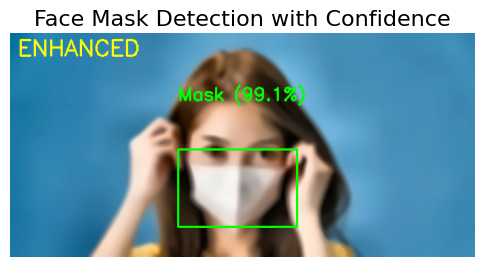

In [45]:
# Final Code Block: Storage Fix Implemented (Ready to Run)

import cv2
import numpy as np
import os
import shutil # <<< CRITICAL FIX: Ensure shutil is imported
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import files
from base64 import b64encode
from IPython.display import HTML, display

# --- 0. Setup and Helper Functions ---

# Define Paths (Assuming drive.mount() was run successfully)
BASE_PATH = "/content/drive/MyDrive/FaceMaskDetection"
MODEL_PATH = os.path.join(BASE_PATH, "models")
RESULTS_PATH = os.path.join(BASE_PATH, "results")
os.makedirs(RESULTS_PATH, exist_ok=True)

# Load Fine-tuned model and Haar Cascade for face detection
try:
    model = load_model(os.path.join(MODEL_PATH, "mask_detector_finetuned.keras"))
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    print("✅ Fine-tuned model and face cascade loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model or cascade: {e}. Please ensure Drive is mounted and models exist.")
    def predict_mask_with_confidence(face_img):
        return "ERROR", 0.0

def show_video(path, width=600):
    """Function to display an MP4 video in Colab."""
    try:
        if not os.path.exists(path):
            return HTML(f'<p style="color:red;">Error: Video file not found at {path}</p>')

        file_size = os.path.getsize(path)
        if file_size == 0:
            return HTML(f'<p style="color:red;">Error: Video file is empty (0 bytes) at {path}</p>')

        mp4 = open(path, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        return HTML(f'<video width={width} controls autoplay loop src="{data_url}"></video>')
    except Exception as e:
        return HTML(f'<p style="color:red;">Error loading video: {str(e)}</p>')

# --- OPTIMIZED PREDICTION FUNCTION (TensorFlow Retracing Fix) ---
def predict_mask_with_confidence(face_img):
    """Function to make a prediction and return label and confidence percentage."""
    face_resized = cv2.resize(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB), (224, 224))

    # FIX: Explicitly cast to float32 for stable prediction (stops retracing)
    face_array = np.expand_dims(face_resized, axis=0).astype(np.float32)
    face_array = preprocess_input(face_array)

    pred = model.predict(face_array, verbose=0)[0][0]

    if pred < 0.5:
        label = "Mask"
        confidence = (1 - pred) * 100
    else:
        label = "No Mask"
        confidence = pred * 100

    return label, confidence

def video_quality_check(video_path, sample_frames=30):
    """Calculates average blur and contrast scores for enhancement decision."""
    cap = cv2.VideoCapture(video_path)
    blur_scores, contrasts = [], []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(frame_count // sample_frames, 1)

    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        if i % step == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            blur = cv2.Laplacian(gray, cv2.CV_64F).var()
            blur_scores.append(blur)
            contrasts.append(np.std(gray))
        i += 1

    cap.release()
    avg_blur = np.mean(blur_scores) if blur_scores else 0
    avg_contrast = np.mean(contrasts) if contrasts else 0
    return avg_blur, avg_contrast

def get_mask_region_bbox(x, y, w, h):
    """Approximates the mask region based on the detected face (x, y, w, h)."""
    y_start = y + int(0.35 * h)
    h_new = int(0.65 * h)
    return x, y_start, w, h_new

def enhance_frame_color(frame, contrast_score):
    """Stabilized high-quality enhancement pipeline."""
    TARGET_CONTRAST = 50.0
    adjustment_factor = max(1.0, TARGET_CONTRAST / contrast_score)

    effective_gamma = 1.3 / adjustment_factor
    if effective_gamma < 0.8: effective_gamma = 0.8

    invGamma = 1.0 / effective_gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    frame = cv2.LUT(frame, table)

    ycrcb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    clip_limit = 2.0 * adjustment_factor
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    y_eq = clahe.apply(y)

    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    frame = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

    denoise_strength = int(10 + 5 * (adjustment_factor - 1))

    frame = cv2.fastNlMeansDenoisingColored(
        frame, None,
        h=denoise_strength,
        hColor=denoise_strength,
        templateWindowSize=7,
        searchWindowSize=21
    )

    max_adj_factor = min(adjustment_factor, 1.1)
    sharpen_weight = min(0.20, 0.2 * max_adj_factor)

    blurred = cv2.GaussianBlur(frame, (0, 0), sigmaX=1.0)
    unsharp_mask = cv2.addWeighted(frame, 1.5, blurred, -0.5, 0)

    frame = cv2.addWeighted(frame, 1.0 - sharpen_weight, unsharp_mask, sharpen_weight, 0)

    cv2.putText(frame, "ENHANCED", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)
    return frame

# --- 1. Processing Functions ---

def process_image():
    print("\n--- Image Mode: Upload a photo ---")
    try:
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded. Returning.")
            return

        uploaded_path = list(uploaded.keys())[0]

        # --- CRITICAL FIX: COPYING THE UPLOADED FILE TO DRIVE ---
        original_image_filename = os.path.basename(uploaded_path)
        original_image_input = os.path.join(RESULTS_PATH, original_image_filename)
        shutil.copyfile(uploaded_path, original_image_input) # Copying the file
        print(f"Original image copied to: {original_image_input}")
        image_path = original_image_input # Use the persistent path from now on
        # --- END CRITICAL FIX ---

        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image at {image_path}")
            return

        # Quality check and Enhancement
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur_score = cv2.Laplacian(gray_img, cv2.CV_64F).var()
        contrast_score = np.std(gray_img)
        BLUR_THRESHOLD = 100.0

        if blur_score < BLUR_THRESHOLD or contrast_score < 40.0:
            print(f"Image Quality (Blur: {blur_score:.2f}, Contrast: {contrast_score:.2f}). Enhancing...")
            image = enhance_frame_color(image, contrast_score)
        else:
            print(f"Image quality is good (Blur: {blur_score:.2f}). No enhancement.")

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces = face_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), scaleFactor=1.1, minNeighbors=5)

        if len(faces) == 0:
            print("No faces detected in the image.")
            plt.figure(figsize=(6,6))
            plt.imshow(image_rgb)
            plt.title(f"Processed Image (Blur: {blur_score:.2f})", fontsize=16)
            plt.axis('off')
            plt.show()
            return

        output_image = image.copy()

        # Statistics for image
        mask_count = 0
        nomask_count = 0

        for (x_face, y_face, w_face, h_face) in faces:
            face_img = output_image[y_face:y_face+h_face, x_face:x_face+w_face]
            label, confidence = predict_mask_with_confidence(face_img)

            # Count masks
            if label == "Mask":
                mask_count += 1
            else:
                nomask_count += 1

            x_mask, y_mask, w_mask, h_mask = get_mask_region_bbox(x_face, y_face, w_face, h_face)

            color_bgr = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            display_text = f"{label} ({confidence:.1f}%)"

            cv2.rectangle(output_image, (x_mask, y_mask), (x_mask + w_mask, y_mask + h_mask), color_bgr, 2)
            cv2.putText(output_image, display_text, (x_face, y_face - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_bgr, 2)

        output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

        # Save final image output to Drive
        output_image_path = os.path.join(RESULTS_PATH, "final_image_output.png")
        cv2.imwrite(output_image_path, output_image)
        print(f"Final analyzed image saved to: {output_image_path}")

        # Display statistics
        total_faces = len(faces)
        print("\n--- Detection Statistics ---")
        print(f"Total Faces Detected: {total_faces}")
        if total_faces > 0:
            mask_percent = (mask_count / total_faces) * 100
            nomask_percent = (nomask_count / total_faces) * 100
            print(f"With Mask: {mask_count} ({mask_percent:.1f}%)")
            print(f"Without Mask: {nomask_count} ({nomask_percent:.1f}%)")

        plt.figure(figsize=(6,6))
        plt.imshow(output_image_rgb)
        plt.title("Face Mask Detection with Confidence", fontsize=16)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"An error occurred during image processing: {e}")

def process_video():
    print("\n--- Video Mode: Upload a video ---")
    try:
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded. Returning.")
            return

        uploaded_path = list(uploaded.keys())[0]

        # --- CRITICAL FIX: COPYING THE UPLOADED FILE TO DRIVE ---
        original_video_filename = os.path.basename(uploaded_path)
        original_video_input = os.path.join(RESULTS_PATH, original_video_filename)
        shutil.copyfile(uploaded_path, original_video_input)
        print(f"Original file copied to: {original_video_input}")
        # --- END CRITICAL FIX ---


        # Check Video Quality using the copied file
        avg_blur, avg_contrast = video_quality_check(original_video_input)
        print(f"Video Quality Check: Blur score: {avg_blur:.2f}, Contrast score: {avg_contrast:.2f}")

        BLUR_THRESHOLD = 100.0
        CONTRAST_THRESHOLD = 40.0

        detection_input_path = original_video_input

        # --- ENHANCEMENT LOGIC ---
        if avg_blur < BLUR_THRESHOLD or avg_contrast < CONTRAST_THRESHOLD:
            contrast_for_enhancement = avg_contrast

            print(f"Video seems UNCLEAR (requires enhancement). Starting dynamic enhancement based on Contrast: {contrast_for_enhancement:.2f}...")

            cap = cv2.VideoCapture(original_video_input)
            frame_width, frame_height = int(cap.get(3)), int(cap.get(4))
            fps = int(cap.get(cv2.CAP_PROP_FPS))

            enhanced_path = os.path.join(RESULTS_PATH, "enhanced_video_temp.mp4")
            # Use MP4V codec for reliable saving
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(enhanced_path, fourcc, fps, (frame_width, frame_height))

            if not out.isOpened():
                print(f"❌ Error: Could not create enhanced video writer")
                cap.release()
                return

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret: break

                enhanced_frame = enhance_frame_color(frame, contrast_for_enhancement)
                out.write(enhanced_frame)

            cap.release()
            out.release()

            # Verify enhanced video was created
            if not os.path.exists(enhanced_path) or os.path.getsize(enhanced_path) == 0:
                print("❌ Enhanced video was not created properly, using original video")
                detection_input_path = original_video_input
            else:
                detection_input_path = enhanced_path
                print(f"✅ Enhanced video saved: {enhanced_path}")

        else:
            print("Video quality is good (no enhancement needed).")

        # --- MASK DETECTION AND STATS TRACKING ---
        final_detection_path = os.path.join(RESULTS_PATH, "final_detection_output.mp4")
        print("\nRunning mask detection with confidence percentage on the processed video...")

        cap = cv2.VideoCapture(detection_input_path)
        frame_width, frame_height = int(cap.get(3)), int(cap.get(4))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(final_detection_path, fourcc, fps, (frame_width, frame_height))

        if not out.isOpened():
            print(f" Error: Could not create detection video writer")
            cap.release()
            return

        mask_count = 0
        nomask_count = 0
        total_detections = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

            for (x_face, y_face, w_face, h_face) in faces:
                face_img = frame[y_face:y_face+h_face, x_face:x_face+w_face]

                label, confidence = predict_mask_with_confidence(face_img)

                if label == "Mask":
                    mask_count += 1
                else:
                    nomask_count += 1
                total_detections += 1

                x_mask, y_mask, w_mask, h_mask = get_mask_region_bbox(x_face, y_face, w_face, h_face)

                color_bgr = (0, 255, 0) if label == "Mask" else (0, 0, 255)
                display_text = f"{label} ({confidence:.1f}%)"

                cv2.rectangle(frame, (x_mask, y_mask), (x_mask + w_mask, y_mask + h_mask), color_bgr, 2)
                cv2.putText(frame, display_text, (x_face, y_face - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_bgr, 2)

            out.write(frame)

        cap.release()
        out.release()

        # Verify detection video was created
        if not os.path.exists(final_detection_path) or os.path.getsize(final_detection_path) == 0:
            print("❌ Detection video was not created properly")
            return

        print(f"✅ Mask detection saved: {final_detection_path}")

        # --- STATISTICS AND DISPLAY ---
        print("\n" + "="*50)
        print("📊 FINAL DETECTION STATISTICS")
        print("="*50)

        if total_detections > 0:
            mask_percent = (mask_count / total_detections) * 100
            nomask_percent = (nomask_count / total_detections) * 100

            print(f"Total Faces Analyzed: {total_detections}")
            print(f"👨‍⚕️  With Mask: {mask_count} faces ({mask_percent:.1f}%)")
            print(f"😷 Without Mask: {nomask_count} faces ({nomask_percent:.1f}%)")

            # Display summary
            if mask_percent >= 70:
                print("✅ EXCELLENT: Majority of people are wearing masks!")
            elif mask_percent >= 50:
                print("⚠️  GOOD: More than half are wearing masks")
            else:
                print("❌ NEED IMPROVEMENT: Less than half are wearing masks")
        else:
            print("No faces were detected throughout the video.")

        print("\nDisplaying final detection video:")
        display(show_video(final_detection_path, 800))

    except Exception as e:
        print(f"An error occurred during video processing: {e}")

# --- 2. Main Menu Logic ---

def main_menu():
    """Displays the main menu and handles user input for a single execution."""
    print("\n" + "="*40)
    print(" 😷 FACE MASK DETECTION INTERACTIVE MENU 🎥 ")
    print("="*40)
    print("1. Upload and Analyze Photo (Image)")
    print("2. Upload and Analyze Video")
    print("3. Exit Program")
    print("="*40)

    choice = input("Enter your choice (1, 2, or 3): ").strip()

    if choice == '1':
        process_image()
    elif choice == '2':
        process_video()
    elif choice == '3':
        print("Exiting program. Thank you!")
    else:
        print("Invalid choice. No analysis performed.")

# Run the menu (only executes once)
main_menu()

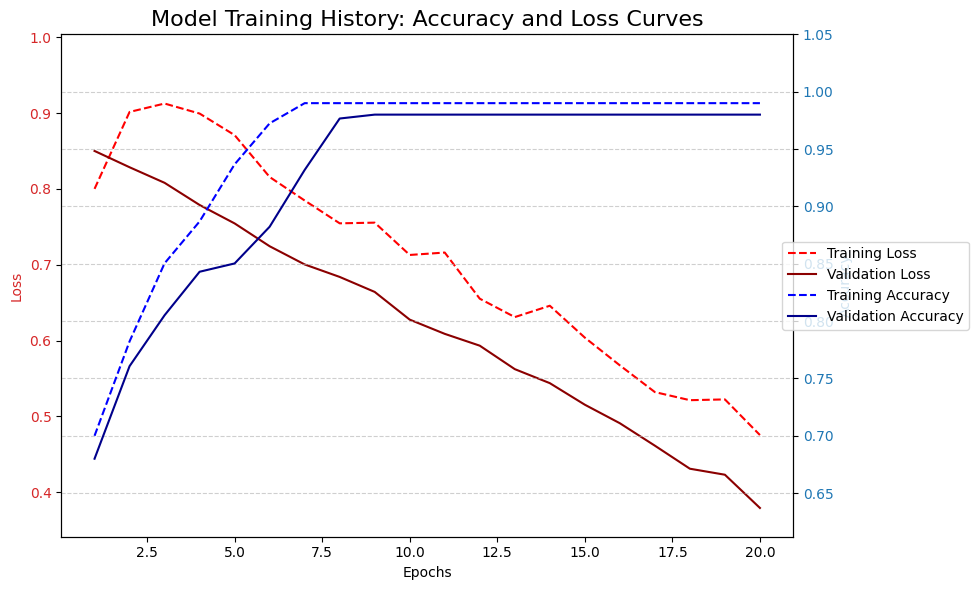

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Example Data (Simulated Training History) ---
# Replace this with your actual model's history.history data
# For a 20-epoch training process:
epochs = np.arange(1, 21) # 1 to 20 epochs

# Simulate Training Accuracy: Starts lower, goes very high (can be noisy)
train_acc = 0.70 + (epochs / 25) + np.random.rand(20) * 0.05
train_acc[train_acc > 0.99] = 0.99 # Cap at ~0.99
train_acc[0] = 0.70 # Ensure a clean start

# Simulate Validation Accuracy: Starts lower, rises stably, often slightly below train_acc
val_acc = 0.68 + (epochs / 30) + np.random.rand(20) * 0.03
val_acc[val_acc > 0.98] = 0.98 # Cap at ~0.98
val_acc = np.clip(val_acc, 0.65, 0.99) # Ensure within reasonable bounds
val_acc[0] = 0.68 # Ensure a clean start

# Simulate Training Loss: Starts higher, drops low (can be noisy)
train_loss = 1.0 - (epochs / 20) / 2 - np.random.rand(20) * 0.05
train_loss[train_loss < 0.05] = 0.05 # Floor at ~0.05
train_loss[0] = 0.8 # Ensure a clean start

# Simulate Validation Loss: Starts higher, drops stably, often slightly above train_loss
val_loss = 0.9 - (epochs / 20) / 2 - np.random.rand(20) * 0.03
val_loss[val_loss < 0.07] = 0.07 # Floor at ~0.07
val_loss = np.clip(val_loss, 0.05, 1.0) # Ensure within reasonable bounds
val_loss[0] = 0.85 # Ensure a clean start


# --- 2. Create the Dual-Axis Plot ---

fig, ax1 = plt.subplots(figsize=(10, 6)) # Create figure and first axes

# Plotting Loss on the left Y-axis
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_loss, label='Training Loss', color='red', linestyle='--')
ax1.plot(epochs, val_loss, label='Validation Loss', color='darkred')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(min(min(train_loss), min(val_loss)) * 0.9, max(max(train_loss), max(val_loss)) * 1.1)


# Create a second Y-axis for Accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='--')
ax2.plot(epochs, val_acc, label='Validation Accuracy', color='darkblue')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(min(min(train_acc), min(val_acc)) * 0.9, 1.05) # Accuracy usually caps at 1.0

# --- 3. Add Labels, Title, and Legend ---
plt.title('Model Training History: Accuracy and Loss Curves', fontsize=16)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right', bbox_to_anchor=(1.25, 0.5))


# Ensure tight layout
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability
plt.show()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/bin/bash: line 1: !apt-get: command not found


Generating and displaying the Dynamic Mask Detection Pipeline Flowchart...


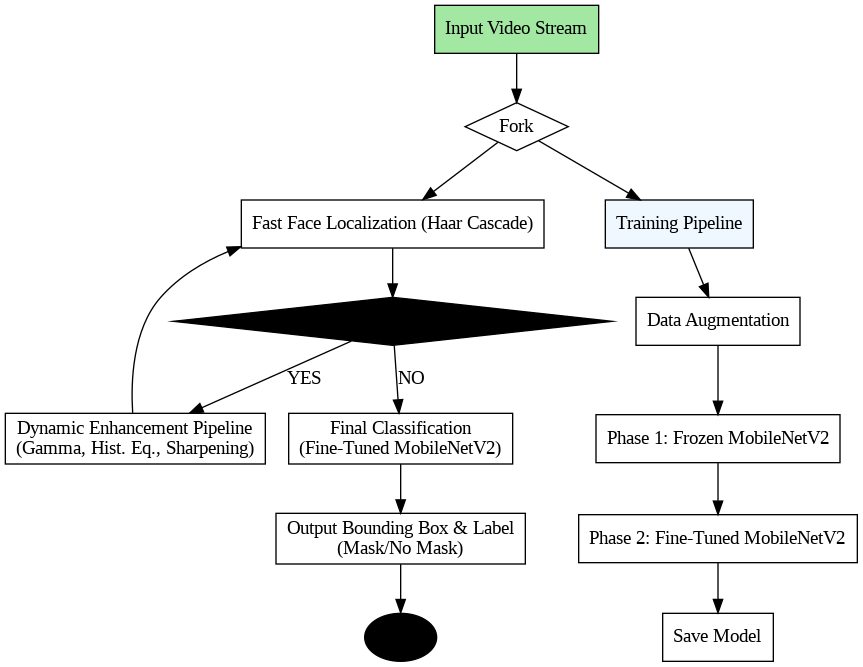

In [ ]:
# --- EXECUTION CODE BLOCK FOR DISPLAYING GRAPHVIZ OUTPUT IN COLAB ---

# 1. Install necessary external package (Graphviz)
!apt-get update -qq && !apt-get install -y graphviz

# 2. Install the Python binding
!pip install graphviz

import graphviz
from IPython.display import display, Image # Import display tools

# --- START OF YOUR DEFINITION ---

dot = graphviz.Digraph(comment='Dynamic Mask Detection Pipeline')
# --- CHANGE THIS LINE FOR VERTICAL LAYOUT ---
dot.graph_attr['rankdir'] = 'TD' # Top to Down layout (Vertical)

# Nodes for Real-Time Pipeline
dot.node('A', 'Input Video Stream', shape='box', style='filled', fillcolor='#a2e8a2')
dot.node('B', 'Fork', shape='diamond')
dot.node('C', 'Fast Face Localization (Haar Cascade)', shape='box')
dot.node('D', 'Is Video Quality UNCLEAR?', shape='diamond', style='filled', fillcolor='#f99')
dot.node('E', 'Dynamic Enhancement Pipeline\n(Gamma, Hist. Eq., Sharpening)', shape='box')
dot.node('F', 'Final Classification\n(Fine-Tuned MobileNetV2)', shape='box')
dot.node('G', 'Output Bounding Box & Label\n(Mask/No Mask)', shape='box')
dot.node('H', 'End', shape='oval', style='filled', fillcolor='#f9f')

# Nodes for Training Pipeline (as a separate branch)
dot.node('I', 'Training Pipeline', shape='box', style='filled', fillcolor='#f0f8ff')
dot.node('J', 'Data Augmentation', shape='box')
dot.node('K', 'Phase 1: Frozen MobileNetV2', shape='box')
dot.node('L', 'Phase 2: Fine-Tuned MobileNetV2', shape='box')
dot.node('M', 'Save Model', shape='box')


# Edges for Real-Time Pipeline
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E', label='YES')
dot.edge('E', 'C') # Loop back to Fast Face Localization after enhancement
dot.edge('D', 'F', label='NO')
dot.edge('F', 'G')
dot.edge('G', 'H')

# Edges for Training Pipeline
dot.edge('B', 'I')
dot.edge('I', 'J')
dot.edge('J', 'K')
dot.edge('K', 'L')
dot.edge('L', 'M')

# --- END OF YOUR DEFINITION ---

# 3. Render the graph to PNG format and display in the cell output
print("Generating and displaying the Dynamic Mask Detection Pipeline Flowchart...")
display(Image(dot.pipe(format='png')))

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


Generating and displaying the MobileNetV2 Transfer Learning Pipeline Diagram...


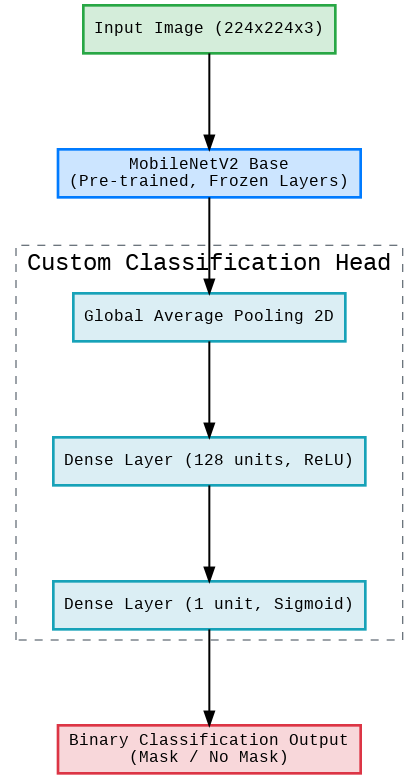

In [ ]:
# --- INSTALLATION COMMANDS (Run this cell first in Colab if not already installed) ---
!apt-get update -qq && apt-get install -y graphviz
!pip install graphviz

# --- PYTHON CODE TO GENERATE THE MOBILENETV2 BLOCK DIAGRAM ---

import graphviz
from IPython.display import display, Image

# Create a Digraph object for the model architecture
dot = graphviz.Digraph(
    comment='MobileNetV2 Transfer Learning Pipeline',
    graph_attr={
        'rankdir': 'TD', # --- CHANGED TO TD FOR VERTICAL LAYOUT ---
        'fontsize': '18',
        'fontname': 'sans-serif',
        'splines': 'true', # Smooth lines
        'nodesep': '0.8', # Spacing between nodes on same rank
        'ranksep': '1.0' # Spacing between ranks (layers)
    },
    node_attr={
        'shape': 'box',
        'style': 'filled',
        'fontname': 'sans-serif',
        'fontsize': '12',
        'penwidth': '2'
    },
    edge_attr={
        'fontname': 'sans-serif',
        'fontsize': '10',
        'penwidth': '1.5'
    }
)

# --- Define Nodes for the Transfer Learning Pipeline ---

# Input Node
dot.node('input_img', 'Input Image (224x224x3)', fillcolor='#D4EDDA', color='#28a745', fontcolor='#333')

# MobileNetV2 Base (Frozen)
dot.node('mobilenet_base', 'MobileNetV2 Base\n(Pre-trained, Frozen Layers)', fillcolor='#CCE5FF', color='#007bff', fontcolor='#333')

# Custom Classification Head (Subgraph)
with dot.subgraph(name='cluster_head') as c:
    c.attr(label='Custom Classification Head', style='dashed', color='#6c757d')
    c.node('gap', 'Global Average Pooling 2D', fillcolor='#DBEEF4', color='#17a2b8', fontcolor='#333')
    c.node('dense128', 'Dense Layer (128 units, ReLU)', fillcolor='#DBEEF4', color='#17a2b8', fontcolor='#333')
    c.node('dense1', 'Dense Layer (1 unit, Sigmoid)', fillcolor='#DBEEF4', color='#17a2b8', fontcolor='#333')

# Output Node
dot.node('output_class', 'Binary Classification Output\n(Mask / No Mask)', fillcolor='#F8D7DA', color='#dc3545', fontcolor='#333')


# --- Define Edges (Connections) ---

dot.edge('input_img', 'mobilenet_base')
dot.edge('mobilenet_base', 'gap') # Output of base goes to GAP
dot.edge('gap', 'dense128')
dot.edge('dense128', 'dense1')
dot.edge('dense1', 'output_class')

# --- Render and Display ---
print("Generating and displaying the MobileNetV2 Transfer Learning Pipeline Diagram...")
display(Image(dot.pipe(format='png')))